In [10]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import layers
import tensorflow.keras.backend as K

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [11]:
# # Set the environment variable to make only GPU 0 visible
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Now, when TensorFlow runs, it should only see GPU 0
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [12]:
def get_data_phase1(LABEL_FIST_HALF):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train/255.0
    x_test = x_test/255.0

    #train_val_ratio = 0.8
    #train_num = int(x_train_val.shape[0]*train_val_ratio)

    
    train_filter = np.where(np.in1d(y_train, LABEL_FIST_HALF))
    test_filter =  np.where(np.in1d(y_test, LABEL_FIST_HALF))
    
    x_train = x_train[train_filter]
    y_train = y_train[train_filter]
    x_test = x_test[test_filter]
    y_test = y_test[test_filter]

    Y_train = tf.keras.utils.to_categorical(y_train, 10)
    Y_test = tf.keras.utils.to_categorical(y_test, 10)
    
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    
    return x_train,x_test,Y_train,Y_test

def getnoisevariance(SNR,rate,P=1):
    # the SNR in args[0] is actually EbN0
    snrdB = SNR + 10*np.log10(rate)
    snr = 10.0**(snrdB/10.0)
    #P_avg = 1
    N0 = P/snr
    return (N0/2)

In [13]:
label_permutation = np.arange(10)
LABEL_FIRST_HALF = label_permutation[:5]

x_train,x_test,Y_train,Y_test = get_data_phase1(LABEL_FIRST_HALF)

In [14]:
label2_list = np.zeros((6,5))
for i in range(6):
    label2_list[i][:] = label_permutation[i:i+5]

In [15]:
label2_list[5]

array([5., 6., 7., 8., 9.])

# model

In [16]:
### normalized Input before 
class GaussianNoiseLayer(layers.Layer):
    def __init__(self, stddev, **kwargs):
        super(GaussianNoiseLayer, self).__init__(**kwargs)
        self.stddev = stddev
    
    def call(self, inputs, training=None):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev)
            return inputs + noise
        else:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev)
            return inputs + noise
    
    def get_config(self):
        config = super(GaussianNoiseLayer, self).get_config()
        config.update({'noise_var': self.stddev})
        return config

In [43]:
### setting 
SAMPLE_NUM = 15000
lambda_list = [0,1,3,5,10]
SNR_train_list = [-3,0,3,7,13,19]
SNR_test_list = np.arange(1,26,3)
acc_list = []
datalist = []

In [18]:
### quantization 


### straightly quantized to 8 bits

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.models import load_model

# -------------------------
# PHASE 1: Train full model and save the encoder as embedding_network
# -------------------------
for snr_train in [15]:
    for lambda_val in lambda_list:
        noise_sd = getnoisevariance(snr_train, 1)
        print("current lambda:", lambda_val)
        K.clear_session()
        tf.keras.utils.set_random_seed(42)

        # Define input layer
        input_layer = tf.keras.layers.Input(shape=x_train[0].shape)

        # Build the encoder
        encoder_1 = tf.keras.layers.Dense(128, activation='relu')(input_layer)
        encoder_2 = tf.keras.layers.Dense(40, activation='relu')(encoder_1)
        #encoder_2 = tf.keras.layers.Dense(40, activation='relu')(encoder_2)

        # Quantize encoder_2's output to 8-bit precision
#         encoder_2_quantized = tf.keras.layers.Lambda(
#             lambda x: tf.quantization.fake_quant_with_min_max_vars(x, min=0.0, max=6.0, num_bits=8)
#         )(encoder_2)
        encoder_2_quantized = tf.keras.layers.Lambda(
            lambda x: tf.quantization.fake_quant_with_min_max_vars(x,min=tf.reduce_min(x),max=tf.reduce_max(x),num_bits=8)
        )(encoder_2)

        # Define and save the embedding network (encoder only)
        embedding_network = tf.keras.Model(inputs=input_layer, outputs=encoder_2_quantized)

        # Continue with the rest of the network (Phase 1 full model)
        normalized_x = tf.keras.layers.Lambda(lambda x: tf.math.tanh(x))(encoder_2_quantized)
        noise_sd = getnoisevariance(snr_train, 1)
        noise_layer = GaussianNoiseLayer(stddev=noise_sd)(normalized_x)

        # Classification branch
        CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu')(noise_layer)
        CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu')(CE_decoder_1)
        CE_output = tf.keras.layers.Dense(10, activation='softmax', name='CE')(CE_decoder_1)

        # Reconstruction branch
        mse_decoder_1 = tf.keras.layers.Dense(256, activation='relu')(noise_layer)
        mse_output = tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid', name='mse')(mse_decoder_1)

        # Construct the full model
        full_model = tf.keras.Model(inputs=input_layer, outputs=[CE_output, mse_output])
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.05, decay_steps=10000, decay_rate=0.8)
        opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
        full_model.compile(optimizer=opt,
                           loss={'CE': 'categorical_crossentropy', 'mse': 'mse'},
                           metrics={'CE': 'accuracy', 'mse': tf.keras.metrics.RootMeanSquaredError()},
                           loss_weights=[1, lambda_val])

        history = full_model.fit(x=x_train, y=(Y_train, x_train),
                                 batch_size=128,
                                 epochs=150,
                                 verbose=0,
                                 validation_data=(x_test, (Y_test, x_test)))

        first_acc = history.history['val_CE_accuracy'][-1]
        print("Phase 1 validation accuracy:", first_acc)

        # Save the embedding network
        embedding_network.save("embedding_network.h5")


        overlap_count = 0
        for i in range(label2_list.shape[0]):
            print("current overlap:", i)
            # Get phase 2 data for current label group
            x_train_2, x_test_2, Y_train_2, Y_test_2 = get_data_phase1(label2_list[5-i])
            for snr_test in [15]:
                print("test snr:", snr_test)
                noise_sd_test = getnoisevariance(snr_test, 1)

                # Load the saved embedding network and freeze its layers.
                # Set compile=False since we only need it for inference.
                embedding_network_2 = tf.keras.models.load_model("embedding_network.h5", compile=False)
                for layer in embedding_network_2.layers:
                    layer.trainable = False

                # Pass the input through the frozen encoder to get the embedding.
                embedded_output = embedding_network_2(input_layer)
                normalized_embedded = tf.keras.layers.Lambda(lambda x: tf.math.tanh(x))(embedded_output)
                noise_layer_1 = GaussianNoiseLayer(stddev=noise_sd_test)(normalized_embedded)

                # Build the decoder (classification branch for phase 2)
                CE_dense_2 = tf.keras.layers.Dense(40, activation='relu')(noise_layer_1)
                CE_dense_3 = tf.keras.layers.Dense(40, activation='relu')(CE_dense_2)
                CE_output2 = tf.keras.layers.Dense(10, activation='softmax', name='CE2')(CE_dense_3)

                # Optionally, define a new reconstruction branch if needed.
                mse_decoder_1_phase2 = tf.keras.layers.Dense(256, activation='relu')(noise_layer_1)
                mse_output_phase2 = tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid', name='mse')(mse_decoder_1_phase2)

                # Construct the phase 2 model that reuses the frozen encoder.
                reconstructed_model = tf.keras.Model(inputs=input_layer, outputs=[CE_output2, mse_output_phase2])

                # Compile the phase 2 model.
                lr_schedule_phase2 = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=3e-2, decay_steps=10000, decay_rate=0.8)
                opt_phase2 = tf.keras.optimizers.SGD(learning_rate=lr_schedule_phase2)
                reconstructed_model.compile(optimizer=opt_phase2,
                                            loss={'CE2': 'categorical_crossentropy', 'mse': 'mse'},
                                            loss_weights=[1, 0],
                                            metrics={'CE2': 'accuracy', 'mse': 'mean_squared_error'})

                history2 = reconstructed_model.fit(x=x_train_2, y=(Y_train_2, x_train_2),
                                                    batch_size=256,
                                                    epochs=100,
                                                    verbose=0,
                                                    validation_data=(x_test_2, (Y_test_2, x_test_2)))

                results = reconstructed_model.evaluate(x=x_test_2, y=(Y_test_2, x_test_2))
                acc_list.append(results[3])

                savedata = {"lambda": lambda_val,
                            "first lr": 0.05,
                            "first batchsize": 256,
                            "first accuracy": first_acc,
                            "train snr": snr_train,
                            "test snr": snr_test,
                            "second loss": results[4],
                            "second accuracy": results[3],
                            "overlap": overlap_count}
                datalist.append(savedata)
                overlap_count += 1

                print("Phase 2 final accuracy:", results[3])


current lambda: 0
Phase 1 validation accuracy: 0.9922164082527161
current overlap: 0
test snr: 15
152/152 [==============================] - 0s 2ms/step - loss: 0.3000 - CE2_loss: 0.3000 - mse_loss: 0.2322 - CE2_accuracy: 0.8990 - mse_mean_squared_error: 0.2322
Phase 2 final accuracy: 0.8989920020103455
current overlap: 1
test snr: 15
152/152 [==============================] - 0s 2ms/step - loss: 0.2385 - CE2_loss: 0.2385 - mse_loss: 0.2318 - CE2_accuracy: 0.9222 - mse_mean_squared_error: 0.2318
Phase 2 final accuracy: 0.922217607498169
current overlap: 2
test snr: 15
153/153 [==============================] - 0s 2ms/step - loss: 0.2086 - CE2_loss: 0.2086 - mse_loss: 0.2324 - CE2_accuracy: 0.9283 - mse_mean_squared_error: 0.2324
Phase 2 final accuracy: 0.9283367395401001
current overlap: 3
test snr: 15
153/153 [==============================] - 0s 2ms/step - loss: 0.1776 - CE2_loss: 0.1776 - mse_loss: 0.2309 - CE2_accuracy: 0.9409 - mse_mean_squared_error: 0.2309
Phase 2 final accuracy

In [49]:
df = pd.DataFrame(datalist)
df.to_csv("RLA_MNIST_quanti.csv", index=False)

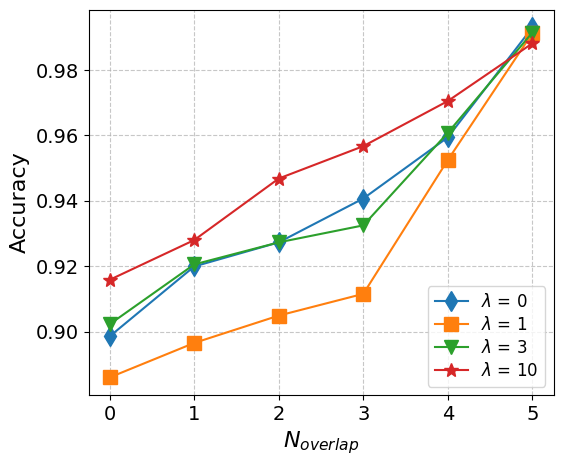

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert datalist to DataFrame
df = pd.DataFrame(datalist[24:])

# Check if DataFrame is empty
if df.empty:
    print("The datalist is empty. No plot to generate.")
else:
    # Define overlap list
    overlap_list = [0,1,2,3,4,5]

    # Get unique lambda values (sorted)
    unique_lambdas = sorted(df["lambda"].unique())

    # Define distinct markers for each lambda value
    markers = ["d", "s", "v", "*", "^", "o", "p", "h", "x", "<"]

    # Assign overlaps based on order in dataset (assuming groups of 6 per lambda)
    df["overlap"] = np.tile(overlap_list, len(df) // len(overlap_list))

    # Initialize plot
    plt.figure(figsize=(6, 5))

    # Plot each lambda's curve
    for i, lambda_val in enumerate(unique_lambdas):
        subset = df[df["lambda"] == lambda_val]  # Filter by lambda
        plt.plot(subset["overlap"], subset["second accuracy"], 
                 marker=markers[i % len(markers)], markersize=10, linestyle='-', 
                 label=f"$\lambda$ = {lambda_val}")

    # Labels and Formatting
    plt.xlabel("$N_{overlap}$", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.xticks(overlap_list, fontsize=14)  # Ensure correct x-ticks
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right', labelspacing=0.3, fontsize=12)

    # Show plot
    plt.show()


In [24]:
## original with relu
from tensorflow.keras.models import load_model

embeddingDim = 80

batchsize = 256

for snr_train in [0]:# SNR_train_list:
    for lambda_val in lambda_list:#lambda_list:
        noise_sd = getnoisevariance(snr_train,1)
        print("current lambda: ",lambda_val )
        K.clear_session()
        tf.keras.utils.set_random_seed(42)

        input_layer = tf.keras.layers.Input(x_train[0].shape)
        encoder_1 = tf.keras.layers.Dense(128, activation='relu')(input_layer)
        encoder_2 =  tf.keras.layers.Dense(40, activation='relu')(encoder_1)
        encoder_2 =  tf.keras.layers.Dense(40, activation='relu')(encoder_2)
        ## first loss: classification 
        noise_sd = getnoisevariance(snr_train,1)
        normalized_x = tf.keras.layers.Lambda(lambda x: tf.math.tanh(x))(encoder_2)
        noise_layer = GaussianNoiseLayer(stddev = noise_sd)(normalized_x)

        CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu')(noise_layer)
        CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu')(CE_decoder_1)
        #CE_decoder_2 = tf.keras.layers.Dense(80, activation='relu')(CE_decoder_1)
        CE_output = tf.keras.layers.Dense(10,activation = 'softmax',name='CE')(CE_decoder_1)

        ## second loss: reconstruction
        mse_decoder_1 = tf.keras.layers.Dense(256, activation='relu')(noise_layer)

        mse_output = tf.keras.layers.Dense(x_train.shape[1],activation = 'sigmoid',name='mse')(mse_decoder_1)  

        model = tf.keras.Model(inputs = input_layer, outputs = [CE_output,mse_output])
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.05,
        decay_steps=10000,
        decay_rate=0.8)
        opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
        model.compile(optimizer=opt,
                      loss = {'CE' : 'categorical_crossentropy', 
                              'mse' : 'mse'},
                      metrics = {'CE' : 'accuracy', 
                                 'mse': tf.keras.metrics.RootMeanSquaredError()},
                      loss_weights=[1, lambda_val])

        history = model.fit(x=x_train, y=(Y_train,x_train),
                            batch_size=256,
                            epochs=100,
                            verbose=1,
                            validation_data=(x_test, (Y_test,x_test)))
        
        first_acc = history.history['val_CE_accuracy'][-1]
        print("current acc: ",first_acc)
        print("training phase 2")

        embedding_network.save("embedding_network.h5")
        
        overlap_count = 0
        for i in range(label2_list.shape[0]):
            print("current overlap: ",(i))
            x_train_2,x_test_2,Y_train_2,Y_test_2 = get_data_phase1(label2_list[5-i])
            for snr_test in [15]: 
                print("test snr: ", snr_test)
                noise_sd_test = getnoisevariance(snr_test,1)
                embedding_network_2 = load_model("embedding_network.h5")
                for layer in embedding_network_2.layers:
                    layer.trainable = False

                noise_layer_1 = GaussianNoiseLayer(stddev = noise_sd_test)(normalized_x)
                CE_dense_2 = layers.Dense(40, activation='relu')(noise_layer_1)
                CE_dense_3 = layers.Dense(40, activation='relu')(CE_dense_2)
                CE_output1 = tf.keras.layers.Dense(10,activation = 'softmax',name='CE2')(CE_dense_3)

                reconstructed_model = tf.keras.models.Model(inputs = input_layer, outputs = [CE_output1,mse_output])
                reconstructed_model.layers[1].trainable = False
                reconstructed_model.layers[2].trainable = False
                reconstructed_model.layers[3].trainable = False


                lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=3e-2,
                decay_steps=10000,
                decay_rate=0.8)
                opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
                # Compile the models

                reconstructed_model.compile(optimizer=opt, 
                            loss = {'CE2' : 'categorical_crossentropy', 
                                      'mse' : 'mse'
                                     },              loss_weights=[1, 0],
                              metrics = {'CE2' : 'accuracy', 
                                         'mse': "mean_squared_error"
                                       }
                             )

                history1 = reconstructed_model.fit(x=x_train_2, y=(Y_train_2,x_train_2),
                                    batch_size=256,
                                    epochs=100,
                                    verbose=0,
                                    validation_data=(x_test_2, (Y_test_2,x_test_2)))

                results = reconstructed_model.evaluate(x = x_test_2, y = (Y_test_2,x_test_2))
                acc_list.append(results[3])

                savedata = {"lambda":lambda_val,
                            "first lr":0.05,
                            "first batchsize":256,
                            "first accuracy":first_acc,
                            "train snr":snr_train,
                            "test snr":snr_test,
                            "second loss":results[4],
                            "second accuracy":results[3],
                            "overlap":overlap_count}
                

                datalist.append(savedata)
                overlap_count += 1

                print("final acc:", results[3])



In [ ]:
datalist_quan = []

### log quantization

In [22]:
import tensorflow as tf
import numpy as np

# Choose Quantization Method: 'log' or 'minmax'
QUANTIZATION_METHOD = 'log'  # Change to 'minmax' if needed

# Logarithmic Quantization Function
def log_quantize(x, alpha=10, levels=256):
    Z_sign = tf.sign(x)
    Z_log = Z_sign * tf.math.log1p(alpha * tf.abs(x))
    Z_min = tf.reduce_min(Z_log)
    Z_max = tf.reduce_max(Z_log)
    Z_scaled = (Z_log - Z_min) / (Z_max - Z_min)
    Z_quantized = tf.round(Z_scaled * (levels - 1))
    return Z_quantized, Z_min, Z_max, alpha

# Logarithmic Dequantization Function
def log_dequantize(Z_quantized, Z_min, Z_max, alpha=10, levels=256):
    Z_scaled = Z_quantized / (levels - 1)
    Z_log = Z_scaled * (Z_max - Z_min) + Z_min
    return tf.sign(Z_log) * (tf.exp(tf.abs(Z_log) / alpha) - 1)

class QuantizationLayer(tf.keras.layers.Layer):
    def __init__(self, method='log'):
        super(QuantizationLayer, self).__init__()
        self.method = method

    def call(self, inputs, training=True):  
        if training:
            # 🔹 Apply STE: Forward uses quantized values, backward uses original inputs
            quantized_x, Z_min, Z_max = self.quantize(inputs)
            return inputs + tf.stop_gradient(quantized_x - inputs), Z_min, Z_max
        else:
            return self.quantize(inputs)

    def quantize(self, x):
        if self.method == 'log':
            Z_quantized, Z_min, Z_max, alpha = log_quantize(x)
        else:
            Z_quantized, Z_min, Z_max = min_max_quantize(x)
        return Z_quantized, Z_min, Z_max


# Custom Dequantization Layer
class DequantizationLayer(tf.keras.layers.Layer):
    def __init__(self, method='log'):
        super(DequantizationLayer, self).__init__()
        self.method = method

    def call(self, inputs):
        Z_quantized, Z_min, Z_max = inputs
        if self.method == 'log':
            return log_dequantize(Z_quantized, Z_min, Z_max)
        else:
            return min_max_dequantize(Z_quantized, Z_min, Z_max)

# Model Definition
embeddingDim = 80
batchsize = 256


for snr_train in [15]:
    for lambda_val in lambda_list:
        noise_sd = getnoisevariance(snr_train, 1)
        print("Current lambda: ", lambda_val)
        tf.keras.backend.clear_session()
        tf.keras.utils.set_random_seed(42)

        # Input Layer
        input_layer = tf.keras.layers.Input(x_train[0].shape)
        encoder_1 = tf.keras.layers.Dense(128, activation='relu',name="encoder_1")(input_layer)
        encoder_2 = tf.keras.layers.Dense(40, activation='relu', name="encoder_2")(encoder_1)
        encoder_2 = tf.keras.layers.Dense(40, activation='relu', name="encoder_3")(encoder_2)

        # Quantization
        quantization_layer = QuantizationLayer(method=QUANTIZATION_METHOD)
        quantized_x, Z_min, Z_max = quantization_layer(encoder_2, training=True)  

        # Apply Noise Layer
        noise_layer = GaussianNoiseLayer(stddev=noise_sd)(quantized_x)

        # Apply Dequantization AFTER noise layer
        dequantized_x = DequantizationLayer(method=QUANTIZATION_METHOD)((noise_layer, Z_min, Z_max))

        # Classification Decoder
        CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu', name="CE_decoder_1")(dequantized_x)
        CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu', name="CE_decoder_2")(CE_decoder_1)
        CE_output = tf.keras.layers.Dense(10, activation='softmax', name='CE')(CE_decoder_1)

        # Reconstruction Decoder
        mse_decoder_1 = tf.keras.layers.Dense(256, activation='relu', name="MSE_decoder_1")(dequantized_x)
        mse_output = tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid', name='mse')(mse_decoder_1)

        # Create Phase 1 Model
        model = tf.keras.Model(inputs=input_layer, outputs=[CE_output, mse_output])
        opt = tf.keras.optimizers.Adam(learning_rate=0.005)

        # Training Phase 1
        model.compile(optimizer=opt,
                      loss={'CE': 'categorical_crossentropy', 'mse': 'mse'},
                      metrics={'CE': 'accuracy', 'mse': tf.keras.metrics.RootMeanSquaredError()},
                      loss_weights=[1, lambda_val])

        history = model.fit(x_train, (Y_train, x_train),
                            batch_size=256,
                            epochs=100,
                            verbose=0,
                            validation_data=(x_test, (Y_test, x_test)))

        first_acc = history.history['val_CE_accuracy'][-1]
        print("Current accuracy: ", first_acc)

        # 🔹 Freezing Encoder for Phase 2
        for layer in model.layers:
            if "encoder" in layer.name:  
                layer.trainable = False
        
        overlap_count = 0
        # Phase 2 Training
        for i in range(label2_list.shape[0]):
            print("Current overlap: ", i)
            x_train_2, x_test_2, Y_train_2, Y_test_2 = get_data_phase1(label2_list[5 - i])
            
            for snr_test in [15]:
                print("Test SNR: ", snr_test)
                noise_sd_test = getnoisevariance(snr_test, 1)

                # Use frozen encoder layers from Phase 1
                input_layer_2 = model.input  
                encoder_output_2 = model.get_layer("encoder_3").output  

                # Apply quantization, noise, and dequantization (Quantization Enabled in Inference)
                quantized_x_2, Z_min_2, Z_max_2 = quantization_layer(encoder_output_2, training=False)  # 🔹 Apply quantization now
                noise_layer_2 = GaussianNoiseLayer(stddev=noise_sd_test)(quantized_x_2)
                dequantized_x_2 = DequantizationLayer(method=QUANTIZATION_METHOD)((noise_layer_2, Z_min_2, Z_max_2))

                # Classification Decoder
                CE_dense_2 = tf.keras.layers.Dense(40, activation='relu')(dequantized_x_2)
                CE_dense_3 = tf.keras.layers.Dense(40, activation='relu')(CE_dense_2)
                CE_output1 = tf.keras.layers.Dense(10, activation='softmax', name='CE2')(CE_dense_3)

                # Reconstruction Decoder
                mse_decoder_2 = tf.keras.layers.Dense(256, activation='relu')(dequantized_x_2)
                mse_output_2 = tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid', name='mse')(mse_decoder_2)

                reconstructed_model = tf.keras.models.Model(inputs=input_layer_2, outputs=[CE_output1, mse_output_2])
                reconstructed_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                                            loss={'CE2': 'categorical_crossentropy', 'mse': 'mse'},
                                            loss_weights=[1, 0],
                                            metrics={'CE2': 'accuracy', 'mse': 'mean_squared_error'})

                history1 = reconstructed_model.fit(x_train_2, (Y_train_2, x_train_2),
                                                   batch_size=256,
                                                   epochs=100,
                                                   verbose=0,
                                                   validation_data=(x_test_2, (Y_test_2, x_test_2)))

                results = reconstructed_model.evaluate(x_test_2, (Y_test_2, x_test_2))
                
                savedata = {"lambda":lambda_val,
                            "first lr":0.05,
                            "first batchsize":256,
                            "first accuracy":first_acc,
                            "train snr":snr_train,
                            "test snr":snr_test,
                            "second loss":results[4],
                            "second accuracy":results[3],
                            "overlap":overlap_count}
                

                datalist_quan.append(savedata)
                overlap_count += 1
                print("Final accuracy:", results[3])


Current lambda:  0
Current accuracy:  0.9896867275238037
Current overlap:  0
Test SNR:  15
152/152 [==============================] - 0s 2ms/step - loss: 0.7730 - CE2_loss: 0.7730 - mse_loss: 0.2374 - CE2_accuracy: 0.7167 - mse_mean_squared_error: 0.2374
Final accuracy: 0.7167249321937561
Current overlap:  1
Test SNR:  15
152/152 [==============================] - 0s 2ms/step - loss: 0.6865 - CE2_loss: 0.6865 - mse_loss: 0.2390 - CE2_accuracy: 0.7371 - mse_mean_squared_error: 0.2390
Final accuracy: 0.7370707392692566
Current overlap:  2
Test SNR:  15
153/153 [==============================] - 0s 2ms/step - loss: 0.5330 - CE2_loss: 0.5330 - mse_loss: 0.2397 - CE2_accuracy: 0.8006 - mse_mean_squared_error: 0.2397
Final accuracy: 0.8006160259246826
Current overlap:  3
Test SNR:  15
153/153 [==============================] - 0s 2ms/step - loss: 0.3910 - CE2_loss: 0.3910 - mse_loss: 0.2317 - CE2_accuracy: 0.8572 - mse_mean_squared_error: 0.2317
Final accuracy: 0.8572014570236206
Current ove

In [35]:
import tensorflow as tf
import numpy as np

# Compute Average Bits Per Symbol (Shannon Entropy)
def compute_average_bits_per_symbol(Z_quantized):
    """
    Computes the entropy-based average bit representation of the quantized values.
    """
    Z_flat = Z_quantized.flatten()  # Convert to 1D array
    unique_values, counts = np.unique(Z_flat, return_counts=True)
    probabilities = counts / np.sum(counts)  # Compute probabilities
    entropy = -np.sum(probabilities * np.log2(probabilities))  # Shannon entropy
    return entropy

# Create a sub-model to extract quantized output
encoder_model = tf.keras.Model(inputs=model.input, 
                               outputs=model.get_layer("quantization_layer").output[0])

# Use `.predict()` to get NumPy values
Z_quantized_numpy = encoder_model.predict(x_test)

# Compute average bits per symbol
avg_bits = compute_average_bits_per_symbol(Z_quantized_numpy)

print(f"Average Bits Per Symbol: {avg_bits:.4f} bits")


161/161 [==============================] - 0s 789us/step
Average Bits Per Symbol: 2.1721 bits


In [ ]:
import tensorflow as tf
import numpy as np
datalist_quan_8 = []
# Choose Quantization Method: 'log' or 'minmax'
QUANTIZATION_METHOD = 'log'  # Change to 'minmax' if needed

# Logarithmic Quantization Function
def log_quantize(x, alpha=5, levels=8):
    Z_sign = tf.sign(x)
    Z_log = Z_sign * tf.math.log1p(alpha * tf.abs(x))
    Z_min = tf.reduce_min(Z_log)
    Z_max = tf.reduce_max(Z_log)
    Z_scaled = (Z_log - Z_min) / (Z_max - Z_min)
    Z_quantized = tf.round(Z_scaled * (levels - 1))
    return Z_quantized, Z_min, Z_max, alpha

# Logarithmic Dequantization Function
def log_dequantize(Z_quantized, Z_min, Z_max, alpha=5, levels=8):
    Z_scaled = Z_quantized / (levels - 1)
    Z_log = Z_scaled * (Z_max - Z_min) + Z_min
    return tf.sign(Z_log) * (tf.exp(tf.abs(Z_log) / alpha) - 1)

def min_max_quantize(Z, bit_depth=8):
    #Z_min, Z_max = Z.min(), Z.max()
    Z_min = tf.reduce_min(Z)
    Z_max = tf.reduce_max(Z)
    scale = (2**bit_depth - 1) / (Z_max - Z_min)
    Z_quantized = ((Z - Z_min) * scale).round().byte()
    return Z_quantized, Z_min, Z_max

def min_max_dequantize(Z_quantized, Z_min, Z_max, bit_depth=8):
    scale = (Z_max - Z_min) / (2**bit_depth - 1)
    return Z_quantized.float() * scale + Z_min

class QuantizationLayer(tf.keras.layers.Layer):
    def __init__(self, method='log'):
        super(QuantizationLayer, self).__init__()
        self.method = method

    def call(self, inputs, training=True):  
        if training:
            # Apply STE: Forward uses quantized values, backward uses original inputs
            quantized_x, Z_min, Z_max = self.quantize(inputs)
            return inputs + tf.stop_gradient(quantized_x - inputs), Z_min, Z_max
        else:
            return self.quantize(inputs)

    def quantize(self, x):
        if self.method == 'log':
            Z_quantized, Z_min, Z_max, alpha = log_quantize(x)
        else:
            Z_quantized, Z_min, Z_max = min_max_quantize(x)
        return Z_quantized, Z_min, Z_max


# Custom Dequantization Layer
class DequantizationLayer(tf.keras.layers.Layer):
    def __init__(self, method='log'):
        super(DequantizationLayer, self).__init__()
        self.method = method

    def call(self, inputs):
        Z_quantized, Z_min, Z_max = inputs
        if self.method == 'log':
            return log_dequantize(Z_quantized, Z_min, Z_max)
        else:
            return min_max_dequantize(Z_quantized, Z_min, Z_max)

# Model Definition
embeddingDim = 80
batchsize = 256

for i in range(3):
    for snr_train in [0]:
        for lambda_val in lambda_list:
            noise_sd = getnoisevariance(snr_train, 1)
            print("Current lambda: ", lambda_val)
            tf.keras.backend.clear_session()
            tf.keras.utils.set_random_seed(42)

            # Input Layer
            input_layer = tf.keras.layers.Input(x_train[0].shape)
            encoder_1 = tf.keras.layers.Dense(128, activation='relu', name="encoder_1")(input_layer)
            encoder_2 = tf.keras.layers.Dense(40, activation='relu', name="encoder_2")(encoder_1)
            encoder_2 = tf.keras.layers.Dense(40, activation='relu', name="encoder_3")(encoder_2)

            # Quantization
            quantization_layer = QuantizationLayer(method=QUANTIZATION_METHOD)
            quantized_x, Z_min, Z_max = quantization_layer(encoder_2, training=True)  

            # Apply Noise Layer
            noise_layer = GaussianNoiseLayer(stddev=noise_sd)(quantized_x)

            # Apply Dequantization AFTER noise layer
            dequantized_x = DequantizationLayer(method=QUANTIZATION_METHOD)((noise_layer, Z_min, Z_max))

            # Classification Decoder
            CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu', name="CE_decoder_1")(dequantized_x)
            CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu', name="CE_decoder_2")(CE_decoder_1)
            CE_output = tf.keras.layers.Dense(10, activation='softmax', name='CE')(CE_decoder_1)

            # Reconstruction Decoder
            mse_decoder_1 = tf.keras.layers.Dense(256, activation='relu', name="MSE_decoder_1")(dequantized_x)
            mse_output = tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid', name='mse')(mse_decoder_1)

            # Create Phase 1 Model
            model = tf.keras.Model(inputs=input_layer, outputs=[CE_output, mse_output])
            opt = tf.keras.optimizers.Adam(learning_rate=0.005)

            # Training Phase 1
            model.compile(optimizer=opt,
                          loss={'CE': 'categorical_crossentropy', 'mse': 'mse'},
                          metrics={'CE': 'accuracy', 'mse': tf.keras.metrics.RootMeanSquaredError()},
                          loss_weights=[1, lambda_val])

            history = model.fit(x_train, (Y_train, x_train),
                                batch_size=256,
                                epochs=100,
                                verbose=0,
                                validation_data=(x_test, (Y_test, x_test)))

            first_acc = history.history['val_CE_accuracy'][-1]
            print("Current accuracy: ", first_acc)

            # Freezing Encoder for Phase 2
            for layer in model.layers:
                if "encoder" in layer.name:  
                    layer.trainable = False

            overlap_count = 0
            # Phase 2 Training
            for i in range(label2_list.shape[0]):
                print("Current overlap: ", i)
                x_train_2, x_test_2, Y_train_2, Y_test_2 = get_data_phase1(label2_list[5 - i])

                for snr_test in [15]:
                    print("Test SNR: ", snr_test)
                    noise_sd_test = getnoisevariance(snr_test, 1)

                    # Use frozen encoder layers from Phase 1
                    input_layer_2 = model.input  
                    encoder_output_2 = model.get_layer("encoder_3").output  

                    # Apply quantization, noise, and dequantization (Quantization Enabled in Inference)
                    quantized_x_2, Z_min_2, Z_max_2 = quantization_layer(encoder_output_2, training=False)  
                    noise_layer_2 = GaussianNoiseLayer(stddev=noise_sd_test)(quantized_x_2)
                    dequantized_x_2 = DequantizationLayer(method=QUANTIZATION_METHOD)((noise_layer_2, Z_min_2, Z_max_2))

                    # Classification Decoder
                    CE_dense_2 = tf.keras.layers.Dense(40, activation='relu')(dequantized_x_2)
                    CE_dense_3 = tf.keras.layers.Dense(40, activation='relu')(CE_dense_2)
                    CE_output1 = tf.keras.layers.Dense(10, activation='softmax', name='CE2')(CE_dense_3)

                    # Reconstruction Decoder
                    mse_decoder_2 = tf.keras.layers.Dense(256, activation='relu')(dequantized_x_2)
                    mse_output_2 = tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid', name='mse')(mse_decoder_2)

                    reconstructed_model = tf.keras.models.Model(inputs=input_layer_2, outputs=[CE_output1, mse_output_2])
                    reconstructed_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                                                loss={'CE2': 'categorical_crossentropy', 'mse': 'mse'},
                                                loss_weights=[1, 0],
                                                metrics={'CE2': 'accuracy', 'mse': 'mean_squared_error'})

                    history1 = reconstructed_model.fit(x_train_2, (Y_train_2, x_train_2),
                                                       batch_size=256,
                                                       epochs=100,
                                                       verbose=0,
                                                       validation_data=(x_test_2, (Y_test_2, x_test_2)))

                    results = reconstructed_model.evaluate(x_test_2, (Y_test_2, x_test_2))

                    savedata = {"lambda":lambda_val,
                                "first lr":0.05,
                                "first batchsize":256,
                                "first accuracy":first_acc,
                                "train snr":snr_train,
                                "test snr":snr_test,
                                "second loss":results[4],
                                "second accuracy":results[3],
                                "overlap":overlap_count}


                    datalist_quan_8.append(savedata)
                    overlap_count += 1
                    print("Final accuracy:", results[3])


In [69]:
import tensorflow as tf
import numpy as np
datalist_quan_256 = []
# Choose Quantization Method: 'log' or 'minmax'
QUANTIZATION_METHOD = 'log'  # Change to 'minmax' if needed

# Logarithmic Quantization Function
def log_quantize(x, alpha=10, levels=256):
    Z_sign = tf.sign(x)
    Z_log = Z_sign * tf.math.log1p(alpha * tf.abs(x))
    Z_min = tf.reduce_min(Z_log)
    Z_max = tf.reduce_max(Z_log)
    Z_scaled = (Z_log - Z_min) / (Z_max - Z_min)
    Z_quantized = tf.round(Z_scaled * (levels - 1))
    return Z_quantized, Z_min, Z_max, alpha

# Logarithmic Dequantization Function
def log_dequantize(Z_quantized, Z_min, Z_max, alpha=10, levels=256):
    Z_scaled = Z_quantized / (levels - 1)
    Z_log = Z_scaled * (Z_max - Z_min) + Z_min
    return tf.sign(Z_log) * (tf.exp(tf.abs(Z_log) / alpha) - 1)

def min_max_quantize(Z, bit_depth=256):
    #Z_min, Z_max = Z.min(), Z.max()
    Z_min = tf.reduce_min(Z)
    Z_max = tf.reduce_max(Z)
    scale = (2**bit_depth - 1) / (Z_max - Z_min)
    Z_quantized = ((Z - Z_min) * scale).round().byte()
    return Z_quantized, Z_min, Z_max

def min_max_dequantize(Z_quantized, Z_min, Z_max, bit_depth=8):
    scale = (Z_max - Z_min) / (2**bit_depth - 1)
    return Z_quantized.float() * scale + Z_min

class QuantizationLayer(tf.keras.layers.Layer):
    def __init__(self, method='log'):
        super(QuantizationLayer, self).__init__()
        self.method = method

    def call(self, inputs, training=True):  
        if training:
            # Apply STE: Forward uses quantized values, backward uses original inputs
            quantized_x, Z_min, Z_max = self.quantize(inputs)
            return inputs + tf.stop_gradient(quantized_x - inputs), Z_min, Z_max
        else:
            return self.quantize(inputs)

    def quantize(self, x):
        if self.method == 'log':
            Z_quantized, Z_min, Z_max, alpha = log_quantize(x)
        else:
            Z_quantized, Z_min, Z_max = min_max_quantize(x)
        return Z_quantized, Z_min, Z_max


# Custom Dequantization Layer
class DequantizationLayer(tf.keras.layers.Layer):
    def __init__(self, method='log'):
        super(DequantizationLayer, self).__init__()
        self.method = method

    def call(self, inputs):
        Z_quantized, Z_min, Z_max = inputs
        if self.method == 'log':
            return log_dequantize(Z_quantized, Z_min, Z_max)
        else:
            return min_max_dequantize(Z_quantized, Z_min, Z_max)

# Model Definition
embeddingDim = 80
batchsize = 256

for i in range(3):
    for snr_train in [0]:
        for lambda_val in lambda_list:
            noise_sd = getnoisevariance(snr_train, 1)
            print("Current lambda: ", lambda_val)
            tf.keras.backend.clear_session()
            tf.keras.utils.set_random_seed(42)

            # Input Layer
            input_layer = tf.keras.layers.Input(x_train[0].shape)
            encoder_1 = tf.keras.layers.Dense(128, activation='relu', name="encoder_1")(input_layer)
            encoder_2 = tf.keras.layers.Dense(40, activation='relu', name="encoder_2")(encoder_1)
            encoder_2 = tf.keras.layers.Dense(40, activation='relu', name="encoder_3")(encoder_2)

            # Quantization
            quantization_layer = QuantizationLayer(method=QUANTIZATION_METHOD)
            quantized_x, Z_min, Z_max = quantization_layer(encoder_2, training=True)  

            # Apply Noise Layer
            noise_layer = GaussianNoiseLayer(stddev=noise_sd)(quantized_x)

            # Apply Dequantization AFTER noise layer
            dequantized_x = DequantizationLayer(method=QUANTIZATION_METHOD)((noise_layer, Z_min, Z_max))

            # Classification Decoder
            CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu', name="CE_decoder_1")(dequantized_x)
            CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu', name="CE_decoder_2")(CE_decoder_1)
            CE_output = tf.keras.layers.Dense(10, activation='softmax', name='CE')(CE_decoder_1)

            # Reconstruction Decoder
            mse_decoder_1 = tf.keras.layers.Dense(256, activation='relu', name="MSE_decoder_1")(dequantized_x)
            mse_output = tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid', name='mse')(mse_decoder_1)

            # Create Phase 1 Model
            model = tf.keras.Model(inputs=input_layer, outputs=[CE_output, mse_output])
            opt = tf.keras.optimizers.Adam(learning_rate=0.005)

            # Training Phase 1
            model.compile(optimizer=opt,
                          loss={'CE': 'categorical_crossentropy', 'mse': 'mse'},
                          metrics={'CE': 'accuracy', 'mse': tf.keras.metrics.RootMeanSquaredError()},
                          loss_weights=[1, lambda_val])

            history = model.fit(x_train, (Y_train, x_train),
                                batch_size=256,
                                epochs=100,
                                verbose=0,
                                validation_data=(x_test, (Y_test, x_test)))

            first_acc = history.history['val_CE_accuracy'][-1]
            print("Current accuracy: ", first_acc)

            # Freezing Encoder for Phase 2
            for layer in model.layers:
                if "encoder" in layer.name:  
                    layer.trainable = False

            overlap_count = 0
            # Phase 2 Training
            for i in range(label2_list.shape[0]):
                print("Current overlap: ", i)
                x_train_2, x_test_2, Y_train_2, Y_test_2 = get_data_phase1(label2_list[5 - i])

                for snr_test in [15]:
                    print("Test SNR: ", snr_test)
                    noise_sd_test = getnoisevariance(snr_test, 1)

                    # Use frozen encoder layers from Phase 1
                    input_layer_2 = model.input  
                    encoder_output_2 = model.get_layer("encoder_3").output  

                    # Apply quantization, noise, and dequantization (Quantization Enabled in Inference)
                    quantized_x_2, Z_min_2, Z_max_2 = quantization_layer(encoder_output_2, training=False)  
                    noise_layer_2 = GaussianNoiseLayer(stddev=noise_sd_test)(quantized_x_2)
                    dequantized_x_2 = DequantizationLayer(method=QUANTIZATION_METHOD)((noise_layer_2, Z_min_2, Z_max_2))

                    # Classification Decoder
                    CE_dense_2 = tf.keras.layers.Dense(40, activation='relu')(dequantized_x_2)
                    CE_dense_3 = tf.keras.layers.Dense(40, activation='relu')(CE_dense_2)
                    CE_output1 = tf.keras.layers.Dense(10, activation='softmax', name='CE2')(CE_dense_3)

                    # Reconstruction Decoder
                    mse_decoder_2 = tf.keras.layers.Dense(256, activation='relu')(dequantized_x_2)
                    mse_output_2 = tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid', name='mse')(mse_decoder_2)

                    reconstructed_model = tf.keras.models.Model(inputs=input_layer_2, outputs=[CE_output1, mse_output_2])
                    reconstructed_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                                                loss={'CE2': 'categorical_crossentropy', 'mse': 'mse'},
                                                loss_weights=[1, 0],
                                                metrics={'CE2': 'accuracy', 'mse': 'mean_squared_error'})

                    history1 = reconstructed_model.fit(x_train_2, (Y_train_2, x_train_2),
                                                       batch_size=256,
                                                       epochs=100,
                                                       verbose=0,
                                                       validation_data=(x_test_2, (Y_test_2, x_test_2)))

                    results = reconstructed_model.evaluate(x_test_2, (Y_test_2, x_test_2))

                    savedata = {"lambda":lambda_val,
                                "first lr":0.05,
                                "first batchsize":256,
                                "first accuracy":first_acc,
                                "train snr":snr_train,
                                "test snr":snr_test,
                                "second loss":results[4],
                                "second accuracy":results[3],
                                "overlap":overlap_count}


                    datalist_quan_256.append(savedata)
                    overlap_count += 1
                    print("Final accuracy:", results[3])


Current lambda:  0
Current accuracy:  0.9904650449752808
Current overlap:  0
Test SNR:  15
152/152 [==============================] - 0s 2ms/step - loss: 0.8349 - CE2_loss: 0.8349 - mse_loss: 0.2413 - CE2_accuracy: 0.6855 - mse_mean_squared_error: 0.2413
Final accuracy: 0.6854556798934937
Current overlap:  1
Test SNR:  15
152/152 [==============================] - 0s 2ms/step - loss: 0.7271 - CE2_loss: 0.7271 - mse_loss: 0.2463 - CE2_accuracy: 0.7062 - mse_mean_squared_error: 0.2463
Final accuracy: 0.7062473893165588
Current overlap:  2
Test SNR:  15
153/153 [==============================] - 0s 2ms/step - loss: 0.5889 - CE2_loss: 0.5889 - mse_loss: 0.2420 - CE2_accuracy: 0.7698 - mse_mean_squared_error: 0.2420
Final accuracy: 0.76981520652771
Current overlap:  3
Test SNR:  15
153/153 [==============================] - 0s 2ms/step - loss: 0.4130 - CE2_loss: 0.4130 - mse_loss: 0.2399 - CE2_accuracy: 0.8359 - mse_mean_squared_error: 0.2399
Final accuracy: 0.8358637690544128
Current overl

In [64]:
mid_log256 = np.median(np.array(pd.DataFrame(datalist_quan_8)['second accuracy'].to_list()).reshape(3,-1),axis=0).reshape(6,-1)

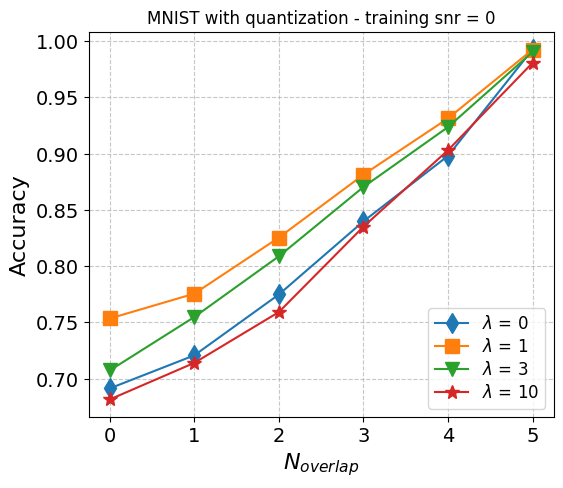

In [71]:
mid_log256 = np.mean(np.array(pd.DataFrame(datalist_quan_8)['second accuracy'].to_list()).reshape(3,-1),axis=0).reshape(-1,6)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert datalist to DataFrame
df = pd.DataFrame(datalist_quan[:24])

# Check if DataFrame is empty
if df.empty:
    print("The datalist is empty. No plot to generate.")
else:
    # Define overlap list
    overlap_list = [0,1,2,3,4,5]

    # Get unique lambda values (sorted)
    unique_lambdas = sorted(df["lambda"].unique())

    # Define distinct markers for each lambda value
    markers = ["d", "s", "v", "*", "^", "o", "p", "h", "x", "<"]

    # Assign overlaps based on order in dataset (assuming groups of 6 per lambda)
    df["overlap"] = np.tile(overlap_list, len(df) // len(overlap_list))

    # Initialize plot
    plt.figure(figsize=(6, 5))

    # Plot each lambda's curve
    count =  0
    for i, lambda_val in enumerate(unique_lambdas):
        subset = df[df["lambda"] == lambda_val]  # Filter by lambda
        plt.plot(subset["overlap"], mid_log256[count], 
                 marker=markers[i % len(markers)], markersize=10, linestyle='-', 
                 label=f"$\lambda$ = {lambda_val}")
        
        count+=1

    # Labels and Formatting
    plt.title("MNIST with quantization - training snr = 0")
    plt.xlabel("$N_{overlap}$", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.xticks(overlap_list, fontsize=14)  # Ensure correct x-ticks
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right', labelspacing=0.3, fontsize=12)

    # Show plot
    plt.show()


In [58]:
log_quan_list = pd.DataFrame(datalist_quan_8)
log_quan_list.to_csv("log_quan_256.csv",index = False)

In [73]:
import tensorflow as tf
import numpy as np
datalist_quan_minmax = []
# Choose Quantization Method: 'log' or 'minmax'
QUANTIZATION_METHOD = 'minmax'  # Change to 'minmax' if needed

# Logarithmic Quantization Function
def log_quantize(x, alpha=10, levels=256):
    Z_sign = tf.sign(x)
    Z_log = Z_sign * tf.math.log1p(alpha * tf.abs(x))
    Z_min = tf.reduce_min(Z_log)
    Z_max = tf.reduce_max(Z_log)
    Z_scaled = (Z_log - Z_min) / (Z_max - Z_min)
    Z_quantized = tf.round(Z_scaled * (levels - 1))
    return Z_quantized, Z_min, Z_max, alpha

# Logarithmic Dequantization Function
def log_dequantize(Z_quantized, Z_min, Z_max, alpha=10, levels=256):
    Z_scaled = Z_quantized / (levels - 1)
    Z_log = Z_scaled * (Z_max - Z_min) + Z_min
    return tf.sign(Z_log) * (tf.exp(tf.abs(Z_log) / alpha) - 1)

def min_max_quantize(Z, bit_depth=256):
    """
    Min-Max Quantization using TensorFlow operations.
    
    Parameters:
        Z (tf.Tensor): Input tensor to be quantized.
        bit_depth (int): Number of bits for quantization (default=8).
        
    Returns:
        Z_quantized (tf.Tensor): Quantized tensor.
        Z_min (tf.Tensor): Minimum value of input tensor.
        Z_max (tf.Tensor): Maximum value of input tensor.
    """
    Z_min = tf.reduce_min(Z, keepdims=True)  # Avoid zero-dim tensor issue
    Z_max = tf.reduce_max(Z, keepdims=True)

    # Avoid division by zero in case Z_min == Z_max
    epsilon = 1e-8
    scale = (Z_max - Z_min + epsilon) / (2**bit_depth - 1)
    
    # Apply quantization
    Z_quantized = tf.round((Z - Z_min) / scale)

    return Z_quantized, Z_min, Z_max

def min_max_dequantize(Z_quantized, Z_min, Z_max, bit_depth=256):
    """
    Min-Max Dequantization using TensorFlow operations.
    
    Parameters:
        Z_quantized (tf.Tensor): Quantized tensor.
        Z_min (tf.Tensor): Minimum value of original input tensor.
        Z_max (tf.Tensor): Maximum value of original input tensor.
        bit_depth (int): Number of bits used in quantization (default=8).
        
    Returns:
        Z_dequantized (tf.Tensor): Dequantized tensor.
    """
    # Compute scale factor
    epsilon = 1e-8  # Small value to avoid division by zero
    scale = (Z_max - Z_min + epsilon) / (2**bit_depth - 1)

    # Apply dequantization
    Z_dequantized = Z_quantized * scale + Z_min

    return Z_dequantized


class QuantizationLayer(tf.keras.layers.Layer):
    def __init__(self, method='log'):
        super(QuantizationLayer, self).__init__()
        self.method = method

    def call(self, inputs, training=True):  
        if training:
            # Apply STE: Forward uses quantized values, backward uses original inputs
            quantized_x, Z_min, Z_max = self.quantize(inputs)
            return inputs + tf.stop_gradient(quantized_x - inputs), Z_min, Z_max
        else:
            return self.quantize(inputs)

    def quantize(self, x):
        if self.method == 'log':
            Z_quantized, Z_min, Z_max, alpha = log_quantize(x)
        else:
            Z_quantized, Z_min, Z_max = min_max_quantize(x)
        return Z_quantized, Z_min, Z_max


# Custom Dequantization Layer
class DequantizationLayer(tf.keras.layers.Layer):
    def __init__(self, method='log'):
        super(DequantizationLayer, self).__init__()
        self.method = method

    def call(self, inputs):
        Z_quantized, Z_min, Z_max = inputs
        if self.method == 'log':
            return log_dequantize(Z_quantized, Z_min, Z_max)
        else:
            return min_max_dequantize(Z_quantized, Z_min, Z_max)

# Model Definition
embeddingDim = 80
batchsize = 256

for i in range(3):
    for snr_train in [15]:
        for lambda_val in lambda_list:
            noise_sd = getnoisevariance(snr_train, 1)
            print("Current lambda: ", lambda_val)
            tf.keras.backend.clear_session()
            tf.keras.utils.set_random_seed(42)

            # Input Layer
            input_layer = tf.keras.layers.Input(x_train[0].shape)
            encoder_1 = tf.keras.layers.Dense(128, activation='relu', name="encoder_1")(input_layer)
            encoder_2 = tf.keras.layers.Dense(40, activation='relu', name="encoder_2")(encoder_1)
            encoder_2 = tf.keras.layers.Dense(40, activation='relu', name="encoder_3")(encoder_2)

            # Quantization
            quantization_layer = QuantizationLayer(method=QUANTIZATION_METHOD)
            quantized_x, Z_min, Z_max = quantization_layer(encoder_2, training=True)  

            # Apply Noise Layer
            noise_layer = GaussianNoiseLayer(stddev=noise_sd)(quantized_x)

            # Apply Dequantization AFTER noise layer
            dequantized_x = DequantizationLayer(method=QUANTIZATION_METHOD)((noise_layer, Z_min, Z_max))

            # Classification Decoder
            CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu', name="CE_decoder_1")(dequantized_x)
            CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu', name="CE_decoder_2")(CE_decoder_1)
            CE_output = tf.keras.layers.Dense(10, activation='softmax', name='CE')(CE_decoder_1)

            # Reconstruction Decoder
            mse_decoder_1 = tf.keras.layers.Dense(256, activation='relu', name="MSE_decoder_1")(dequantized_x)
            mse_output = tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid', name='mse')(mse_decoder_1)

            # Create Phase 1 Model
            model = tf.keras.Model(inputs=input_layer, outputs=[CE_output, mse_output])
            opt = tf.keras.optimizers.Adam(learning_rate=0.005)

            # Training Phase 1
            model.compile(optimizer=opt,
                          loss={'CE': 'categorical_crossentropy', 'mse': 'mse'},
                          metrics={'CE': 'accuracy', 'mse': tf.keras.metrics.RootMeanSquaredError()},
                          loss_weights=[1, lambda_val])

            history = model.fit(x_train, (Y_train, x_train),
                                batch_size=256,
                                epochs=100,
                                verbose=1,
                                validation_data=(x_test, (Y_test, x_test)))

            first_acc = history.history['val_CE_accuracy'][-1]
            print("Current accuracy: ", first_acc)

            # Freezing Encoder for Phase 2
            for layer in model.layers:
                if "encoder" in layer.name:  
                    layer.trainable = False

            overlap_count = 0
            # Phase 2 Training
            for i in range(label2_list.shape[0]):
                print("Current overlap: ", i)
                x_train_2, x_test_2, Y_train_2, Y_test_2 = get_data_phase1(label2_list[5 - i])

                for snr_test in [15]:
                    print("Test SNR: ", snr_test)
                    noise_sd_test = getnoisevariance(snr_test, 1)

                    # Use frozen encoder layers from Phase 1
                    input_layer_2 = model.input  
                    encoder_output_2 = model.get_layer("encoder_3").output  

                    # Apply quantization, noise, and dequantization (Quantization Enabled in Inference)
                    quantized_x_2, Z_min_2, Z_max_2 = quantization_layer(encoder_output_2, training=False)
                    noise_layer_2 = GaussianNoiseLayer(stddev=noise_sd_test)(quantized_x_2)
                    dequantized_x_2 = DequantizationLayer(method=QUANTIZATION_METHOD)((noise_layer_2, Z_min_2, Z_max_2))

                    # Classification Decoder
                    CE_dense_2 = tf.keras.layers.Dense(40, activation='relu')(dequantized_x_2)
                    CE_dense_3 = tf.keras.layers.Dense(40, activation='relu')(CE_dense_2)
                    CE_output1 = tf.keras.layers.Dense(10, activation='softmax', name='CE2')(CE_dense_3)

                    # Reconstruction Decoder
                    mse_decoder_2 = tf.keras.layers.Dense(256, activation='relu')(dequantized_x_2)
                    mse_output_2 = tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid', name='mse')(mse_decoder_2)

                    reconstructed_model = tf.keras.models.Model(inputs=input_layer_2, outputs=[CE_output1, mse_output_2])
                    reconstructed_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                                                loss={'CE2': 'categorical_crossentropy', 'mse': 'mse'},
                                                loss_weights=[1, 0],
                                                metrics={'CE2': 'accuracy', 'mse': 'mean_squared_error'})

                    history1 = reconstructed_model.fit(x_train_2, (Y_train_2, x_train_2),
                                                       batch_size=256,
                                                       epochs=100,
                                                       verbose=0,
                                                       validation_data=(x_test_2, (Y_test_2, x_test_2)))

                    results = reconstructed_model.evaluate(x_test_2, (Y_test_2, x_test_2))

                    savedata = {"lambda":lambda_val,
                                "first lr":0.05,
                                "first batchsize":256,
                                "first accuracy":first_acc,
                                "train snr":snr_train,
                                "test snr":snr_test,
                                "second loss":results[4],
                                "second accuracy":results[3],
                                "overlap":overlap_count}


                    datalist_quan_minmax.append(savedata)
                    overlap_count += 1
                    print("Final accuracy:", results[3])


Current lambda:  0
Epoch 1/100
120/120 [==============================] - 3s 6ms/step - loss: nan - CE_loss: nan - mse_loss: nan - CE_accuracy: 0.1936 - mse_root_mean_squared_error: nan - val_loss: nan - val_CE_loss: nan - val_mse_loss: nan - val_CE_accuracy: 0.1907 - val_mse_root_mean_squared_error: nan
Epoch 2/100
120/120 [==============================] - 1s 5ms/step - loss: nan - CE_loss: nan - mse_loss: nan - CE_accuracy: 0.1936 - mse_root_mean_squared_error: nan - val_loss: nan - val_CE_loss: nan - val_mse_loss: nan - val_CE_accuracy: 0.1907 - val_mse_root_mean_squared_error: nan
Epoch 3/100
120/120 [==============================] - 1s 5ms/step - loss: nan - CE_loss: nan - mse_loss: nan - CE_accuracy: 0.1936 - mse_root_mean_squared_error: nan - val_loss: nan - val_CE_loss: nan - val_mse_loss: nan - val_CE_accuracy: 0.1907 - val_mse_root_mean_squared_error: nan
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: nan - CE_loss: nan - mse_loss: nan - CE_accur

KeyboardInterrupt: 

### test board

In [2]:
import tensorflow as tf
# Logarithmic Quantization Function
def log_quantize(x, alpha=10, levels=256):
    Z_sign = tf.sign(x)
    Z_log = Z_sign * tf.math.log1p(alpha * tf.abs(x))

    # Preserve min/max scale
    Z_min = tf.reduce_min(Z_log)
    Z_max = tf.reduce_max(Z_log)

    # Normalized quantization
    Z_scaled = (Z_log - Z_min) / (Z_max - Z_min)  # Normalize to [0,1]
    Z_quantized = tf.round(Z_scaled * (levels - 1))  # Scale to integer range

    return Z_quantized, Z_min, Z_max, alpha

# Logarithmic Dequantization Function
def log_dequantize(Z_quantized, Z_min, Z_max, alpha=10, levels=256):
    Z_scaled = Z_quantized / (levels - 1)
    Z_log = Z_scaled * (Z_max - Z_min) + Z_min
    return tf.sign(Z_log) * (tf.exp(tf.abs(Z_log) / alpha) - 1)

# Example Tensor
Z = tf.constant([[0.5, 0.8, 1.2], [-1.0, -0.5, 0.3]], dtype=tf.float32)

# Apply Quantization
Z_quantized, Z_min, Z_max, alpha = log_quantize(Z, levels=256)

# Apply Dequantization
Z_dequantized = log_dequantize(Z_quantized, Z_min, Z_max, levels=256)

# Print Results
print("Original Tensor:\n", Z.numpy())
print("Quantized Tensor:\n", Z_quantized.numpy())
print("Dequantized Tensor:\n", Z_dequantized.numpy())
print("min: ",Z_min, " max: ",Z_max)

2025-02-23 08:45:40.094205: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Original Tensor:
 [[ 0.5  0.8  1.2]
 [-1.  -0.5  0.3]]
Quantized Tensor:
 [[215. 236. 255.]
 [  0.  31. 194.]]
Dequantized Tensor:
 [[ 0.19559789  0.24547493  0.29239225]
 [-0.27098155 -0.19656742  0.14771843]]
min:  tf.Tensor(-2.3978953, shape=(), dtype=float32)  max:  tf.Tensor(2.5649493, shape=(), dtype=float32)


2025-02-23 08:45:43.119934: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 72765 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2025-02-23 08:45:43.121946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78835 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


In [23]:
import tensorflow as tf
import tensorflow_probability as tfp
def estimate_alpha(x, percentile=95):
    """
    Estimate alpha based on a chosen percentile of absolute values in x.
    This ensures that the chosen alpha properly captures the dynamic range of the input.
    """
    x_abs = tf.abs(x)
    x_max = tfp.stats.percentile(x_abs, percentile)
    alpha = 1 / (x_max + 1e-8)  # Ensure non-zero division
    return alpha

estimate_alpha(encoder_2_output)

<tf.Tensor: shape=(), dtype=float32, numpy=0.24898732>

In [4]:
Z_minval = tf.reduce_min(Z)
print(Z_minva)

In [76]:
# Example Tensor
Z = tf.constant([[0.5, 0.8, 1.2], [-1.0, -0.5, 0.3]], dtype=tf.float32)

# Apply Quantization
Z_quantized, Z_min, Z_max = min_max_quantize(Z, bit_depth=8)

# Apply Dequantization
Z_dequantized = min_max_dequantize(Z_quantized, Z_min, Z_max, bit_depth=8)

# Print Results
print("Original Tensor:\n", Z.numpy())
print("Quantized Tensor:\n", Z_quantized.numpy())
print("Dequantized Tensor:\n", Z_dequantized.numpy())


Original Tensor:
 [[ 0.5  0.8  1.2]
 [-1.  -0.5  0.3]]
Quantized Tensor:
 [[174. 209. 255.]
 [  0.  58. 151.]]
Dequantized Tensor:
 [[ 0.5011765   0.8031373   1.2       ]
 [-1.         -0.49960786  0.3027451 ]]


In [78]:
Z_max

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.2]], dtype=float32)>

In [45]:
datalist_quan_new = []
import tensorflow as tf
import numpy as np

# Choose Quantization Method: 'log' or 'minmax'
QUANTIZATION_METHOD = 'log'  # Change to 'minmax' if needed

# Logarithmic Quantization Function
def log_quantize(x, alpha=5, levels=16):
    Z_sign = tf.sign(x)
    Z_log = Z_sign * tf.math.log1p(alpha * tf.abs(x))
    Z_min = tf.reduce_min(Z_log)
    Z_max = tf.reduce_max(Z_log)
    Z_scaled = (Z_log - Z_min) / (Z_max - Z_min)
    Z_quantized = tf.round(Z_scaled * (levels - 1))
    return Z_quantized, Z_min, Z_max, alpha

# Logarithmic Dequantization Function
def log_dequantize(Z_quantized, Z_min, Z_max, alpha=10, levels=16):
    Z_scaled = Z_quantized / (levels - 1)
    Z_log = Z_scaled * (Z_max - Z_min) + Z_min
    return tf.sign(Z_log) * (tf.exp(tf.abs(Z_log) / alpha) - 1)

def min_max_quantize(Z, bit_depth=4):
    #Z_min, Z_max = Z.min(), Z.max()
    Z_min = tf.reduce_min(Z)
    Z_max = tf.reduce_max(Z)
    scale = (2**bit_depth - 1) / (Z_max - Z_min)
    Z_quantized = ((Z - Z_min) * scale).round().byte()
    return Z_quantized, Z_min, Z_max

def min_max_dequantize(Z_quantized, Z_min, Z_max, bit_depth=8):
    scale = (Z_max - Z_min) / (2**bit_depth - 1)
    return Z_quantized.float() * scale + Z_min

class QuantizationLayer(tf.keras.layers.Layer):
    def __init__(self, method='log'):
        super(QuantizationLayer, self).__init__()
        self.method = method

    def call(self, inputs, training=True):  
        if training:
            # Apply STE: Forward uses quantized values, backward uses original inputs
            quantized_x, Z_min, Z_max = self.quantize(inputs)
            return inputs + tf.stop_gradient(quantized_x - inputs), Z_min, Z_max
        else:
            return self.quantize(inputs)

    def quantize(self, x):
        if self.method == 'log':
            Z_quantized, Z_min, Z_max, alpha = log_quantize(x)
        else:
            Z_quantized, Z_min, Z_max = min_max_quantize(x)
        return Z_quantized, Z_min, Z_max


# Custom Dequantization Layer
class DequantizationLayer(tf.keras.layers.Layer):
    def __init__(self, method='log'):
        super(DequantizationLayer, self).__init__()
        self.method = method

    def call(self, inputs):
        Z_quantized, Z_min, Z_max = inputs
        if self.method == 'log':
            return log_dequantize(Z_quantized, Z_min, Z_max)
        else:
            return min_max_dequantize(Z_quantized, Z_min, Z_max)

# Model Definition
embeddingDim = 80
batchsize = 256


for snr_train in [15]:
    for lambda_val in lambda_list:
        noise_sd = getnoisevariance(snr_train, 1)
        print("Current lambda: ", lambda_val)
        tf.keras.backend.clear_session()
        tf.keras.utils.set_random_seed(42)

        # Input Layer
        input_layer = tf.keras.layers.Input(x_train[0].shape)
        encoder_1 = tf.keras.layers.Dense(128, activation='relu', name="encoder_1")(input_layer)
        encoder_2 = tf.keras.layers.Dense(40, activation='relu', name="encoder_2")(encoder_1)
        encoder_2 = tf.keras.layers.Dense(40, activation='relu', name="encoder_3")(encoder_2)

        # Quantization
        quantization_layer = QuantizationLayer(method=QUANTIZATION_METHOD)
        quantized_x, Z_min, Z_max = quantization_layer(encoder_2, training=True)  

        # Apply Noise Layer
        noise_layer = GaussianNoiseLayer(stddev=noise_sd)(quantized_x)

        # Apply Dequantization AFTER noise layer
        dequantized_x = DequantizationLayer(method=QUANTIZATION_METHOD)((noise_layer, Z_min, Z_max))

        # Classification Decoder
        CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu', name="CE_decoder_1")(dequantized_x)
        CE_decoder_1 = tf.keras.layers.Dense(40, activation='relu', name="CE_decoder_2")(CE_decoder_1)
        CE_output = tf.keras.layers.Dense(10, activation='softmax', name='CE')(CE_decoder_1)

        # Reconstruction Decoder
        mse_decoder_1 = tf.keras.layers.Dense(256, activation='relu', name="MSE_decoder_1")(dequantized_x)
        mse_output = tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid', name='mse')(mse_decoder_1)

        # Create Phase 1 Model
        model = tf.keras.Model(inputs=input_layer, outputs=[CE_output, mse_output])
        opt = tf.keras.optimizers.Adam(learning_rate=0.005)

        # Training Phase 1
        model.compile(optimizer=opt,
                      loss={'CE': 'categorical_crossentropy', 'mse': 'mse'},
                      metrics={'CE': 'accuracy', 'mse': tf.keras.metrics.RootMeanSquaredError()},
                      loss_weights=[1, lambda_val])

        history = model.fit(x_train, (Y_train, x_train),
                            batch_size=256,
                            epochs=100,
                            verbose=0,
                            validation_data=(x_test, (Y_test, x_test)))

        first_acc = history.history['val_CE_accuracy'][-1]
        print("Current accuracy: ", first_acc)

        # Freezing Encoder for Phase 2
        for layer in model.layers:
            if "encoder" in layer.name:  
                layer.trainable = False

        overlap_count = 0
        # Phase 2 Training
        for i in range(label2_list.shape[0]):
            print("Current overlap: ", i)
            x_train_2, x_test_2, Y_train_2, Y_test_2 = get_data_phase1(label2_list[5 - i])

            for snr_test in [15]:
                print("Test SNR: ", snr_test)
                noise_sd_test = getnoisevariance(snr_test, 1)

                # Use frozen encoder layers from Phase 1
                input_layer_2 = model.input  
                encoder_output_2 = model.get_layer("encoder_3").output  

                # Apply quantization, noise, and dequantization (Quantization Enabled in Inference)
                quantized_x_2, Z_min_2, Z_max_2 = quantization_layer(encoder_output_2, training=False)  # 🔹 Apply quantization now
                noise_layer_2 = GaussianNoiseLayer(stddev=noise_sd_test)(quantized_x_2)
                dequantized_x_2 = DequantizationLayer(method=QUANTIZATION_METHOD)((noise_layer_2, Z_min_2, Z_max_2))

                # Classification Decoder
                CE_dense_2 = tf.keras.layers.Dense(40, activation='relu')(dequantized_x_2)
                CE_dense_3 = tf.keras.layers.Dense(40, activation='relu')(CE_dense_2)
                CE_output1 = tf.keras.layers.Dense(10, activation='softmax', name='CE2')(CE_dense_3)

                # Reconstruction Decoder
                mse_decoder_2 = tf.keras.layers.Dense(256, activation='relu')(dequantized_x_2)
                mse_output_2 = tf.keras.layers.Dense(x_train.shape[1], activation='sigmoid', name='mse')(mse_decoder_2)

                reconstructed_model = tf.keras.models.Model(inputs=input_layer_2, outputs=[CE_output1, mse_output_2])
                reconstructed_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                                            loss={'CE2': 'categorical_crossentropy', 'mse': 'mse'},
                                            loss_weights=[1, 0],
                                            metrics={'CE2': 'accuracy', 'mse': 'mean_squared_error'})

                history1 = reconstructed_model.fit(x_train_2, (Y_train_2, x_train_2),
                                                   batch_size=256,
                                                   epochs=100,
                                                   verbose=0,
                                                   validation_data=(x_test_2, (Y_test_2, x_test_2)))

                results = reconstructed_model.evaluate(x_test_2, (Y_test_2, x_test_2))

                savedata = {"lambda":lambda_val,
                            "first lr":0.05,
                            "first batchsize":256,
                            "first accuracy":first_acc,
                            "train snr":snr_train,
                            "test snr":snr_test,
                            "second loss":results[4],
                            "second accuracy":results[3],
                            "overlap":overlap_count}


                datalist_quan_new.append(savedata)
                overlap_count += 1
                print("Final accuracy:", results[3])


Current lambda:  0
Current accuracy:  0.9455146789550781
Current overlap:  0
Test SNR:  15
152/152 [==============================] - 0s 2ms/step - loss: 1.1515 - CE2_loss: 1.1515 - mse_loss: 0.2308 - CE2_accuracy: 0.5260 - mse_mean_squared_error: 0.2308
Final accuracy: 0.5260234475135803
Current overlap:  1
Test SNR:  15
152/152 [==============================] - 0s 2ms/step - loss: 1.0081 - CE2_loss: 1.0081 - mse_loss: 0.2311 - CE2_accuracy: 0.5724 - mse_mean_squared_error: 0.2311
Final accuracy: 0.5724037885665894
Current overlap:  2
Test SNR:  15
153/153 [==============================] - 0s 2ms/step - loss: 0.7825 - CE2_loss: 0.7825 - mse_loss: 0.2314 - CE2_accuracy: 0.6756 - mse_mean_squared_error: 0.2314
Final accuracy: 0.675564706325531
Current overlap:  3
Test SNR:  15
153/153 [==============================] - 0s 2ms/step - loss: 0.5269 - CE2_loss: 0.5269 - mse_loss: 0.2303 - CE2_accuracy: 0.8039 - mse_mean_squared_error: 0.2303
Final accuracy: 0.8038572072982788
Current over

In [49]:
len(datalist_quan_new)

24

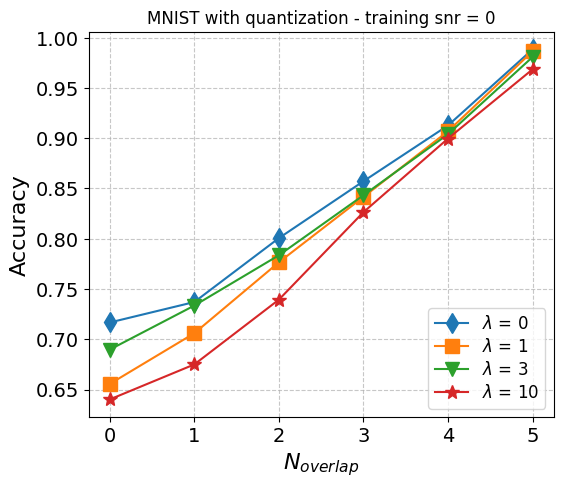

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert datalist to DataFrame
df = pd.DataFrame(datalist_quan[:24])

# Check if DataFrame is empty
if df.empty:
    print("The datalist is empty. No plot to generate.")
else:
    # Define overlap list
    overlap_list = [0,1,2,3,4,5]

    # Get unique lambda values (sorted)
    unique_lambdas = sorted(df["lambda"].unique())

    # Define distinct markers for each lambda value
    markers = ["d", "s", "v", "*", "^", "o", "p", "h", "x", "<"]

    # Assign overlaps based on order in dataset (assuming groups of 6 per lambda)
    df["overlap"] = np.tile(overlap_list, len(df) // len(overlap_list))

    # Initialize plot
    plt.figure(figsize=(6, 5))

    # Plot each lambda's curve
    for i, lambda_val in enumerate(unique_lambdas):
        subset = df[df["lambda"] == lambda_val]  # Filter by lambda
        plt.plot(subset["overlap"], subset["second accuracy"], 
                 marker=markers[i % len(markers)], markersize=10, linestyle='-', 
                 label=f"$\lambda$ = {lambda_val}")

    # Labels and Formatting
    plt.title("MNIST with quantization - training snr = 0")
    plt.xlabel("$N_{overlap}$", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.xticks(overlap_list, fontsize=14)  # Ensure correct x-ticks
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right', labelspacing=0.3, fontsize=12)

    # Show plot
    plt.show()


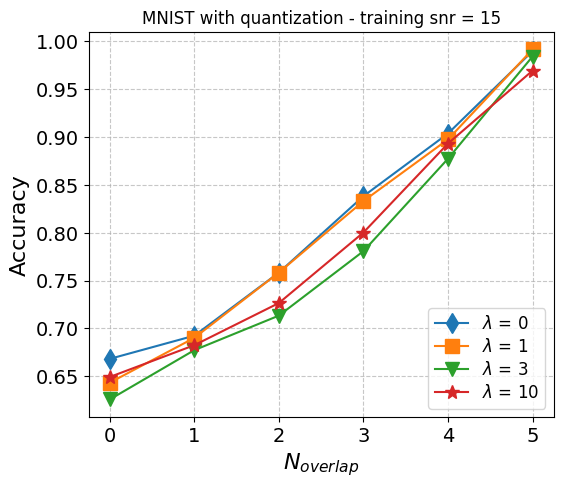

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert datalist to DataFrame
df = pd.DataFrame(datalist_quan[24:])

# Check if DataFrame is empty
if df.empty:
    print("The datalist is empty. No plot to generate.")
else:
    # Define overlap list
    overlap_list = [0,1,2,3,4,5]

    # Get unique lambda values (sorted)
    unique_lambdas = sorted(df["lambda"].unique())

    # Define distinct markers for each lambda value
    markers = ["d", "s", "v", "*", "^", "o", "p", "h", "x", "<"]

    # Assign overlaps based on order in dataset (assuming groups of 6 per lambda)
    df["overlap"] = np.tile(overlap_list, len(df) // len(overlap_list))

    # Initialize plot
    plt.figure(figsize=(6, 5))

    # Plot each lambda's curve
    for i, lambda_val in enumerate(unique_lambdas):
        subset = df[df["lambda"] == lambda_val]  # Filter by lambda
        plt.plot(subset["overlap"], subset["second accuracy"], 
                 marker=markers[i % len(markers)], markersize=10, linestyle='-', 
                 label=f"$\lambda$ = {lambda_val}")

    # Labels and Formatting
    plt.title("MNIST with quantization - training snr = 15")
    plt.xlabel("$N_{overlap}$", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.xticks(overlap_list, fontsize=14)  # Ensure correct x-ticks
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right', labelspacing=0.3, fontsize=12)

    # Show plot
    plt.show()


In [39]:
for i,data in enumerate(datalist[2:]):
    print(f"Entry {i+1}: sec acc: {data['second accuracy']}")

Entry 1: sec acc: 0.809709906578064
Entry 2: sec acc: 0.8220934867858887
Entry 3: sec acc: 0.8359342813491821
Entry 4: sec acc: 0.863561749458313
Entry 5: sec acc: 0.9138784408569336
Entry 6: sec acc: 0.9924109578132629
Entry 7: sec acc: 0.8025097846984863
Entry 8: sec acc: 0.8119569420814514
Entry 9: sec acc: 0.8390143513679504
Entry 10: sec acc: 0.8574066758155823
Entry 11: sec acc: 0.9162542223930359
Entry 12: sec acc: 0.9941622614860535
Entry 13: sec acc: 0.7946924567222595
Entry 14: sec acc: 0.7995448708534241
Entry 15: sec acc: 0.847227931022644
Entry 16: sec acc: 0.8793598413467407
Entry 17: sec acc: 0.9253613352775574


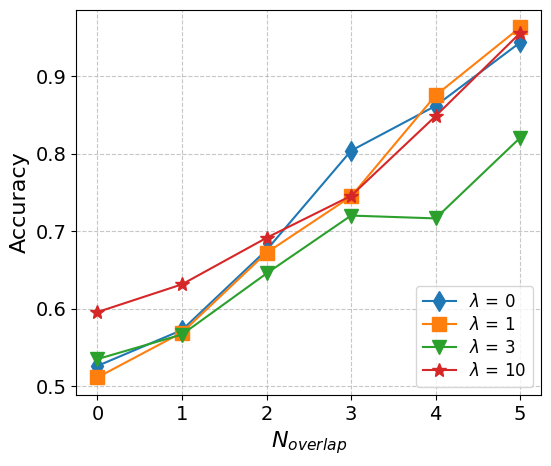

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert datalist to DataFrame
df = pd.DataFrame(datalist_quan_new)

# Check if DataFrame is empty
if df.empty:
    print("The datalist is empty. No plot to generate.")
else:
    # Define overlap list
    overlap_list = [0,1,2,3,4,5]

    # Get unique lambda values (sorted)
    unique_lambdas = sorted(df["lambda"].unique())

    # Define distinct markers for each lambda value
    markers = ["d", "s", "v", "*", "^", "o", "p", "h", "x", "<"]

    # Assign overlaps based on order in dataset (assuming groups of 6 per lambda)
    df["overlap"] = np.tile(overlap_list, len(df) // len(overlap_list))

    # Initialize plot
    plt.figure(figsize=(6, 5))

    # Plot each lambda's curve
    for i, lambda_val in enumerate(unique_lambdas):
        subset = df[df["lambda"] == lambda_val]  # Filter by lambda
        plt.plot(subset["overlap"], subset["second accuracy"], 
                 marker=markers[i % len(markers)], markersize=10, linestyle='-', 
                 label=f"$\lambda$ = {lambda_val}")

    # Labels and Formatting
    plt.xlabel("$N_{overlap}$", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.xticks(overlap_list, fontsize=14)  # Ensure correct x-ticks
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right', labelspacing=0.3, fontsize=12)

    # Show plot
    plt.show()


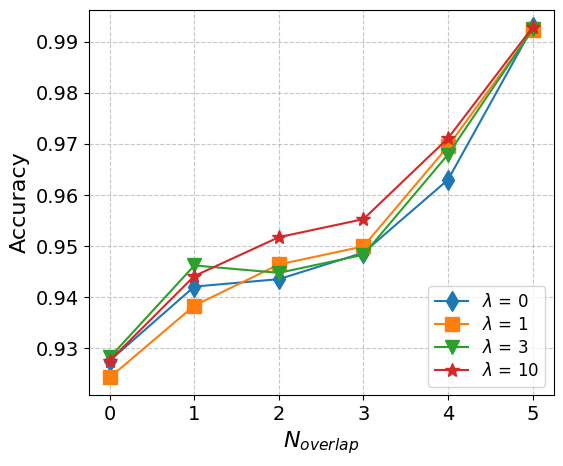

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert datalist to DataFrame
df = pd.DataFrame(datalist_leaky)

# Check if DataFrame is empty
if df.empty:
    print("The datalist is empty. No plot to generate.")
else:
    # Define overlap list
    overlap_list = [0,1,2,3,4,5]

    # Get unique lambda values (sorted)
    unique_lambdas = sorted(df["lambda"].unique())

    # Define distinct markers for each lambda value
    markers = ["d", "s", "v", "*", "^", "o", "p", "h", "x", "<"]

    # Assign overlaps based on order in dataset (assuming groups of 6 per lambda)
    df["overlap"] = np.tile(overlap_list, len(df) // len(overlap_list))

    # Initialize plot
    plt.figure(figsize=(6, 5))

    # Plot each lambda's curve
    for i, lambda_val in enumerate(unique_lambdas):
        subset = df[df["lambda"] == lambda_val]  # Filter by lambda
        plt.plot(subset["overlap"], subset["second accuracy"], 
                 marker=markers[i % len(markers)], markersize=10, linestyle='-', 
                 label=f"$\lambda$ = {lambda_val}")

    # Labels and Formatting
    plt.xlabel("$N_{overlap}$", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.xticks(overlap_list, fontsize=14)  # Ensure correct x-ticks
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right', labelspacing=0.3, fontsize=12)

    # Show plot
    plt.show()


In [19]:
# Convert the dictionary to a DataFrame
import pandas as pd
df = pd.DataFrame(datalist)

# Define the file path and name
file_path = 'RLA_MNIST_snr.xlsx'

# Write the DataFrame to an Excel file
df.to_excel(file_path, index=False)

In [53]:
results = reconstructed_model.evaluate(x = x_test_2, y = (Y_test_2,x_test_2))

161/161 [==============================] - 1s 8ms/step - loss: 0.0553 - CE2_loss: 0.0553 - mse_loss: 0.2388 - CE2_accuracy: 0.9914 - mse_mean_squared_error: 0.2388


In [15]:
getnoisevariance(-3,1)

0.9976311574844399

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          100480      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 40)           5160        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 40)           1640        ['dense_1[0][0]']                
                                                                                              

957/957 [==============================] - 1s 664us/step


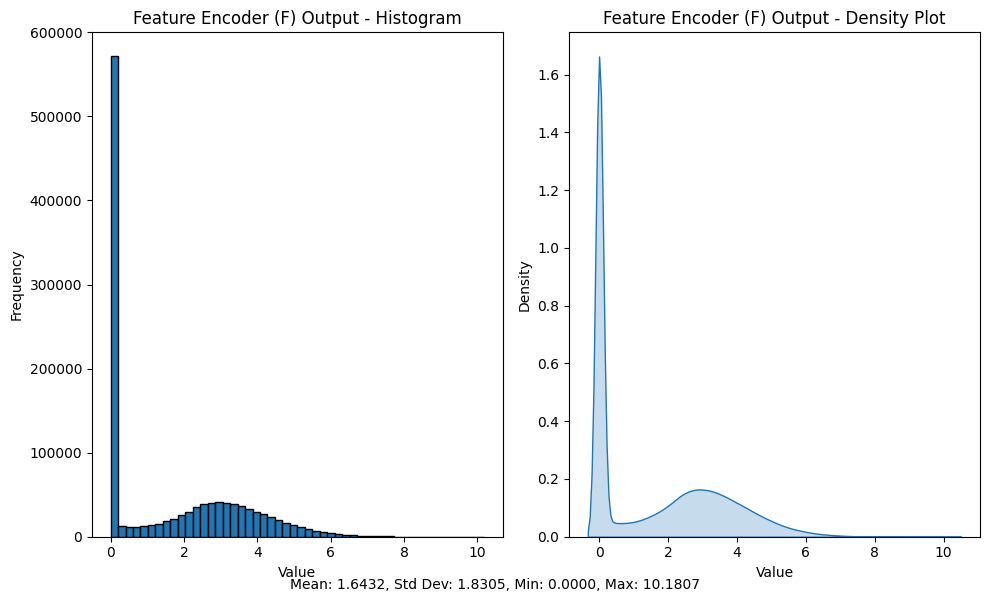

Distribution Statistics:
Mean: 1.6431633234024048
Median: 0.8885136842727661
Standard Deviation: 1.830539345741272
Min: 0.0
Max: 10.180683135986328


In [37]:
import seaborn as sns
def get_encoder_2_output(model, input_data):
    # Create an intermediate model that outputs the encoder_2 layer
    intermediate_model = tf.keras.Model(
        inputs=model.input, 
        outputs=model.get_layer('dense_2').output
    )
    
    # Get the output
    encoder_2_output = intermediate_model.predict(input_data)
    return encoder_2_output


# Plotting function
def plot_distribution(data, title):
    plt.figure(figsize=(10, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(data.flatten(), bins=50, edgecolor='black')
    plt.title(f'{title} - Histogram')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Kernel Density Estimation (KDE) plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(data.flatten(), fill=True)
    plt.title(f'{title} - Density Plot')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # Add overall statistics as text
    plt.figtext(0.5, 0.01, 
                f'Mean: {np.mean(data):.4f}, '
                f'Std Dev: {np.std(data):.4f}, '
                f'Min: {np.min(data):.4f}, '
                f'Max: {np.max(data):.4f}', 
                ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
encoder_2_output = get_encoder_2_output(model, x_train)

plot_distribution(encoder_2_output, 'Feature Encoder (F) Output')

# Optional: Check distribution properties
print("Distribution Statistics:")
print(f"Mean: {np.mean(encoder_2_output)}")
print(f"Median: {np.median(encoder_2_output)}")
print(f"Standard Deviation: {np.std(encoder_2_output)}")
print(f"Min: {np.min(encoder_2_output)}")
print(f"Max: {np.max(encoder_2_output)}")

In [16]:
encoder_2_output = get_encoder_2_output(model, x_train)

957/957 [==============================] - 1s 703us/step


In [40]:
type(encoder_2_output)

numpy.ndarray

In [41]:
encoder_2_output.nbytes / (1024 * 1024)

4.6685791015625

In [38]:
sum((encoder_2_output == 0))

array([10309, 11538, 11567,  8651, 13914, 18235,     0,  8733, 14914,
       30596, 11936, 11504, 12035, 17956, 11589, 11746, 30522, 23645,
        6255, 30596,  7249,     0, 14016,  9111, 18736, 11329, 14620,
        5950,  8350,  5924,     0, 30596, 30595, 30477, 11733, 10100,
       19245, 13008, 12008,  8056])

In [39]:
sum(sum((encoder_2_output == 0)))/(x_train.shape[0]*40)

0.4554059354163943

In [31]:
(x_train.shape[0]*40)

1223840

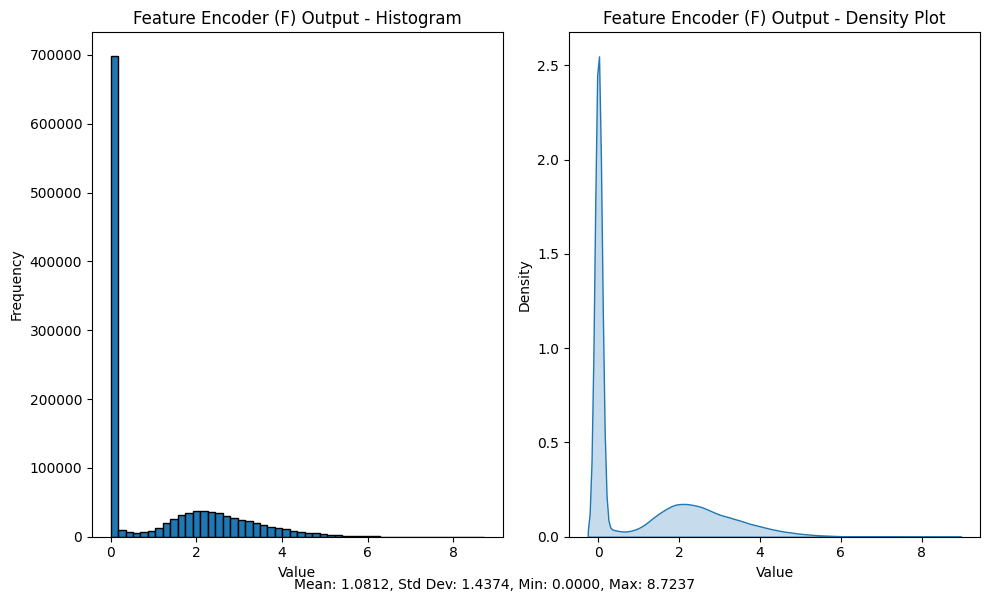

Distribution Statistics:
Mean: 1.081182837486267
Median: 0.0
Standard Deviation: 1.4373655319213867
Min: 0.0
Max: 8.723670959472656


In [29]:
import seaborn as sns
plot_distribution(encoder_2_output, 'Feature Encoder (F) Output')

# Optional: Check distribution properties
print("Distribution Statistics:")
print(f"Mean: {np.mean(encoder_2_output)}")
print(f"Median: {np.median(encoder_2_output)}")
print(f"Standard Deviation: {np.std(encoder_2_output)}")
print(f"Min: {np.min(encoder_2_output)}")
print(f"Max: {np.max(encoder_2_output)}")

957/957 [==============================] - 1s 653us/step


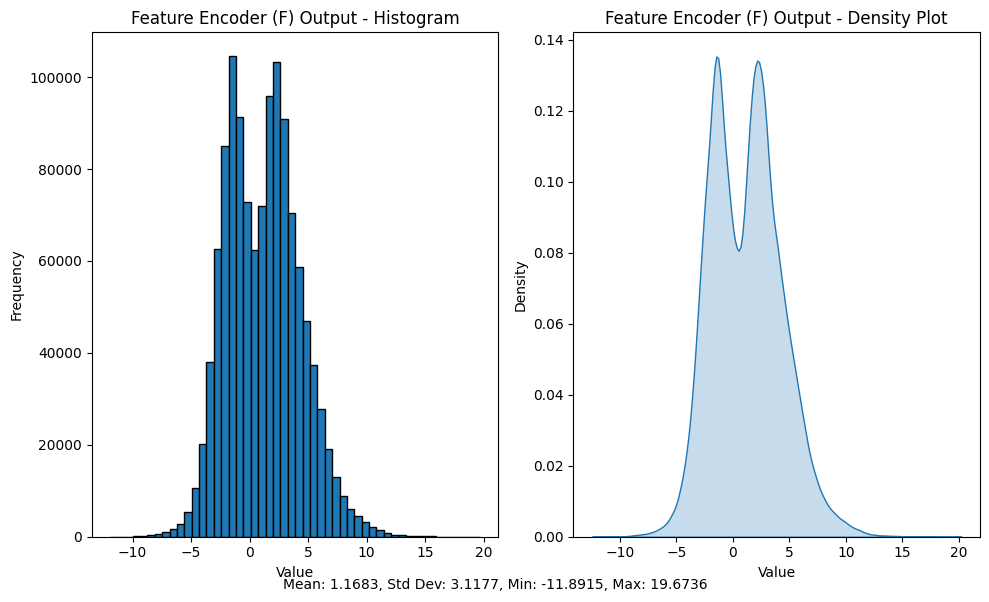

Distribution Statistics:
Mean: 1.168292760848999
Median: 1.2128190994262695
Standard Deviation: 3.117683172225952
Min: -11.8915433883667
Max: 19.673629760742188


In [32]:
import seaborn as sns
def get_encoder_2_output(model, input_data):
    # Create an intermediate model that outputs the encoder_2 layer
    intermediate_model = tf.keras.Model(
        inputs=model.input, 
        outputs=model.get_layer('dense_2').output
    )
    
    # Get the output
    encoder_2_output = intermediate_model.predict(input_data)
    return encoder_2_output


# Plotting function
def plot_distribution(data, title):
    plt.figure(figsize=(10, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(data.flatten(), bins=50, edgecolor='black')
    plt.title(f'{title} - Histogram')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Kernel Density Estimation (KDE) plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(data.flatten(), fill=True)
    plt.title(f'{title} - Density Plot')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # Add overall statistics as text
    plt.figtext(0.5, 0.01, 
                f'Mean: {np.mean(data):.4f}, '
                f'Std Dev: {np.std(data):.4f}, '
                f'Min: {np.min(data):.4f}, '
                f'Max: {np.max(data):.4f}', 
                ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
encoder_2_output = get_encoder_2_output(model, x_train)

plot_distribution(encoder_2_output, 'Feature Encoder (F) Output')

# Optional: Check distribution properties
print("Distribution Statistics:")
print(f"Mean: {np.mean(encoder_2_output)}")
print(f"Median: {np.median(encoder_2_output)}")
print(f"Standard Deviation: {np.std(encoder_2_output)}")
print(f"Min: {np.min(encoder_2_output)}")
print(f"Max: {np.max(encoder_2_output)}")

In [37]:
type(encoder_2_output[0][0])

numpy.float32

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, LeakyReLU, Lambda
embeddingDim = 80

datalist_leaky = []
batchsize = 256

for snr_train in [0]:# SNR_train_list:
    for lambda_val in [0]:#lambda_list:
        noise_sd = getnoisevariance(snr_train,1)
        print("current lambda: ",lambda_val )
        K.clear_session()
        tf.keras.utils.set_random_seed(42)

        input_layer = tf.keras.layers.Input(x_train[0].shape)
        encoder_1 = Dense(128)(input_layer)
        encoder_1 = LeakyReLU(alpha=0.01)(encoder_1)  
        encoder_2 = Dense(40)(encoder_1)
        encoder_2 = LeakyReLU(alpha=0.01)(encoder_2)  
        encoder_2 = Dense(40)(encoder_2)
        encoder_2 = LeakyReLU(alpha=0.01)(encoder_2)
        
        ## first loss: classification 
        noise_sd = getnoisevariance(snr_train,1)
        normalized_x = tf.keras.layers.Lambda(lambda x: tf.math.tanh(x))(encoder_2)
        noise_layer = GaussianNoiseLayer(stddev = noise_sd)(normalized_x)

        CE_decoder_1 = Dense(40)(noise_layer)
        CE_decoder_1 = LeakyReLU(alpha=0.01)(CE_decoder_1)
        CE_decoder_1 = Dense(40)(CE_decoder_1)
        CE_decoder_1 = LeakyReLU(alpha=0.01)(CE_decoder_1) 
        #CE_decoder_2 = tf.keras.layers.Dense(80, activation='relu')(CE_decoder_1)
        CE_output = tf.keras.layers.Dense(10,activation = 'softmax',name='CE')(CE_decoder_1)

        ## second loss: reconstruction
        mse_decoder_1 = tf.keras.layers.Dense(256, activation='relu')(noise_layer)

        mse_output = tf.keras.layers.Dense(x_train.shape[1],activation = 'sigmoid',name='mse')(mse_decoder_1)  

        model = tf.keras.Model(inputs = input_layer, outputs = [CE_output,mse_output])
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.05,
        decay_steps=10000,
        decay_rate=0.8)
        opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
        model.compile(optimizer=opt,
                      loss = {'CE' : 'categorical_crossentropy', 
                              'mse' : 'mse'},
                      metrics = {'CE' : 'accuracy', 
                                 'mse': tf.keras.metrics.RootMeanSquaredError()},
                      loss_weights=[1, lambda_val])

        history = model.fit(x=x_train, y=(Y_train,x_train),
                            batch_size=256,
                            epochs=100,
                            verbose=0,
                            validation_data=(x_test, (Y_test,x_test)))
        
        first_acc = history.history['val_CE_accuracy'][-1]
        print("current acc: ",first_acc)
        print("training phase 2")

#         embedding_network.save("embedding_network.h5")
        
#         overlap_count = 0
#         for i in range(label2_list.shape[0]):
#             print("current overlap: ",(i))
#             x_train_2,x_test_2,Y_train_2,Y_test_2 = get_data_phase1(label2_list[5-i])
#             for snr_test in [15]: 
#                 print("test snr: ", snr_test)
#                 noise_sd_test = getnoisevariance(snr_test,1)
# #                 embedding_network_2 = load_model("embedding_network.h5")
# #                 for layer in embedding_network_2.layers:
# #                     layer.trainable = False

#                 noise_layer_1 = GaussianNoiseLayer(stddev = noise_sd_test)(normalized_x)
#                 CE_dense_2 = layers.Dense(40, activation='relu')(noise_layer_1)
#                 CE_dense_3 = layers.Dense(40, activation='relu')(CE_dense_2)
#                 CE_output1 = tf.keras.layers.Dense(10,activation = 'softmax',name='CE2')(CE_dense_3)

#                 reconstructed_model = tf.keras.models.Model(inputs = input_layer, outputs = [CE_output1,mse_output])
#                 reconstructed_model.layers[1].trainable = False
#                 reconstructed_model.layers[2].trainable = False
#                 reconstructed_model.layers[3].trainable = False


#                 lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#                 initial_learning_rate=3e-2,
#                 decay_steps=10000,
#                 decay_rate=0.8)
#                 opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
#                 # Compile the models

#                 reconstructed_model.compile(optimizer=opt, 
#                             loss = {'CE2' : 'categorical_crossentropy', 
#                                       'mse' : 'mse'
#                                      },              loss_weights=[1, 0],
#                               metrics = {'CE2' : 'accuracy', 
#                                          'mse': "mean_squared_error"
#                                        }
#                              )

#                 history1 = reconstructed_model.fit(x=x_train_2, y=(Y_train_2,x_train_2),
#                                     batch_size=256,
#                                     epochs=100,
#                                     verbose=0,
#                                     validation_data=(x_test_2, (Y_test_2,x_test_2)))

#                 results = reconstructed_model.evaluate(x = x_test_2, y = (Y_test_2,x_test_2))
#                 acc_list.append(results[3])

#                 savedata = {"lambda":lambda_val,
#                             "first lr":0.05,
#                             "first batchsize":256,
#                             "first accuracy":first_acc,
#                             "train snr":snr_train,
#                             "test snr":snr_test,
#                             "second loss":results[4],
#                             "second accuracy":results[3],
#                             "overlap":overlap_count}
                

#                 datalist_leaky.append(savedata)
#                 overlap_count += 1

#                 print("final acc:", results[3])



current lambda:  0
current acc:  0.9900758862495422
training phase 2


In [22]:
def get_encoder_2_output(model, input_data):
    # Create an intermediate model that outputs the encoder_2 layer
    intermediate_model = tf.keras.Model(
        inputs=model.input, 
        outputs=model.get_layer('dense_2').output
    )
    
    # Get the output
    encoder_2_output = intermediate_model.predict(input_data)
    return encoder_2_output

encoder_2_output = get_encoder_2_output(model, x_train)

957/957 [==============================] - 1s 615us/step
